# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

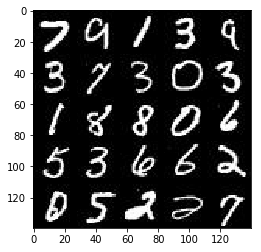

In [2]:
import helper

data_dir = '/input'
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [3]:
# Show number of inputs
print("Number of pictures in mnist: {}".format(len(glob("/input/mnist/*"))))
print("Number of pictures in celeba: {}".format(len(glob("/input/img_align_celeba/*"))))

Number of pictures in mnist: 60000
Number of pictures in celeba: 202599


### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

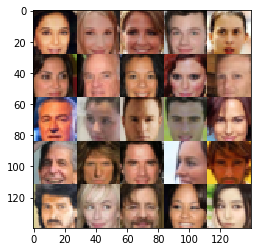

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32)

    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha=0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        # Input size: 28*28*1(MNIST) \\ 28*28*3(seleba)
        conv1 = tf.layers.conv2d(images, 32, (5,5), (2,2), padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        #conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = tf.layers.dropout(conv1, 0.9)        
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        # Input size: 14*14*32
        conv2 = tf.layers.conv2d(conv1, 64, (5,5), (2,2), padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.layers.dropout(conv2, 0.9)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        # Input size: 7*7*64
        conv3 = tf.layers.conv2d(conv2, 128, (5,5), (2,2), padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.layers.dropout(conv3, 0.9)        
        conv3 = tf.maximum(alpha*conv3, conv3)
        
        # Input size: 4*4*128
        flat = tf.reshape(conv3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        output = tf.nn.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        # Fully connected, reshape, normalize and activate
        x = tf.layers.dense(z, 7*7*128)
        x = tf.reshape(x, (-1, 7, 7, 128))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.layers.dropout(x, 0.9)
        x = tf.maximum(alpha*x, x)
        
        # Input size: 7*7*128        
        conv1 = tf.layers.conv2d_transpose(x, 64, (5,5), (2,2), padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.layers.dropout(conv1, 0.9)        
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        # Input size: 14*14*64
        conv2 = tf.layers.conv2d_transpose(conv1, 32, (5,5), (2,2), padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.layers.dropout(conv2, 0.9)        
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        # Input size: 28*28*32
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, (5,5), (1,1), padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())        
        output = tf.nn.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    # Output from generator
    g_output = generator(input_z, out_channel_dim)
    
    # Output from discriminator
    d_real_output, d_real_logits = discriminator(input_real)
    d_fake_output, d_fake_logits = discriminator(g_output, reuse=True)
    
    # Discriminator Loss 
    d_real_loss = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_real_logits)*(1-smooth), logits=d_real_logits))
    d_fake_loss = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_fake_logits), logits=d_fake_logits))
    d_loss = d_real_loss + d_fake_loss
    
    # Generator Loss
    g_loss = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_fake_logits), logits=d_fake_logits))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get graph variables with names
    d_variables = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]
    g_variables = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
    
    # Optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_variables)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_variables)

    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Number of all input images
    n_images = len(glob("/input/img_align_celeba/*")) if data_image_mode =='RGB' else len(glob("/input/mnist/*"))
    
    # TODO: Build Model    
    # tf.reset_default_graph()
    image_channels = data_shape[-1]
    real_input, z_input, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    n_show_images = 25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            # Record the batch number in every epoch
            batch_epoch = 0
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_epoch += 1
                
                # Change images range to consistent with generated images and generate noise vector
                batch_images *= 2 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizer
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr: learning_rate})
                
                # Print generator output every 100 batches
                if batch_epoch % 100 == 0:
                    show_generator_output(sess, n_show_images, z_input, image_channels, data_image_mode)
                    
                # Show loss results every 20 batches
                if batch_epoch % 20 == 0:
                    dloss= sess.run(d_loss, feed_dict={real_input: batch_images, z_input: batch_z})
                    gloss= sess.run(g_loss, feed_dict={z_input: batch_z})                    
                    print("Epoch {}/{}, Image {}/{}: Loss of discriminator: {:.4f}, Loss of generator: {:.4f}".format(
                            epoch_i, epoch_count, batch_epoch*batch_size, n_images, dloss, gloss))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2, Image 640/60000: Loss of discriminator: 0.9168, Loss of generator: 1.1170
Epoch 0/2, Image 1280/60000: Loss of discriminator: 1.0754, Loss of generator: 1.0663
Epoch 0/2, Image 1920/60000: Loss of discriminator: 0.8535, Loss of generator: 1.6507
Epoch 0/2, Image 2560/60000: Loss of discriminator: 0.9982, Loss of generator: 0.9342


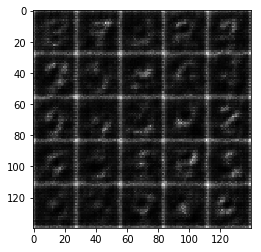

Epoch 0/2, Image 3200/60000: Loss of discriminator: 1.0450, Loss of generator: 1.8467
Epoch 0/2, Image 3840/60000: Loss of discriminator: 1.3896, Loss of generator: 0.5524
Epoch 0/2, Image 4480/60000: Loss of discriminator: 0.9653, Loss of generator: 1.2414
Epoch 0/2, Image 5120/60000: Loss of discriminator: 0.9830, Loss of generator: 1.2551
Epoch 0/2, Image 5760/60000: Loss of discriminator: 1.0805, Loss of generator: 0.9319


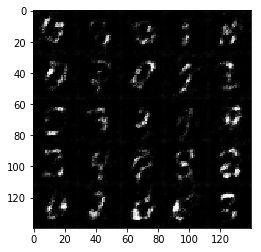

Epoch 0/2, Image 6400/60000: Loss of discriminator: 1.1292, Loss of generator: 0.9811
Epoch 0/2, Image 7040/60000: Loss of discriminator: 0.9686, Loss of generator: 1.0059
Epoch 0/2, Image 7680/60000: Loss of discriminator: 0.9572, Loss of generator: 1.5929
Epoch 0/2, Image 8320/60000: Loss of discriminator: 0.9032, Loss of generator: 1.2132
Epoch 0/2, Image 8960/60000: Loss of discriminator: 0.8223, Loss of generator: 1.4114


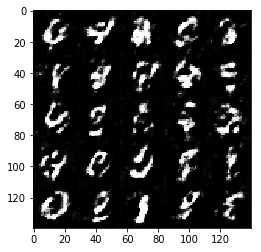

Epoch 0/2, Image 9600/60000: Loss of discriminator: 1.0376, Loss of generator: 0.8769
Epoch 0/2, Image 10240/60000: Loss of discriminator: 0.8717, Loss of generator: 1.5609
Epoch 0/2, Image 10880/60000: Loss of discriminator: 0.9930, Loss of generator: 1.7600
Epoch 0/2, Image 11520/60000: Loss of discriminator: 1.1805, Loss of generator: 0.6697
Epoch 0/2, Image 12160/60000: Loss of discriminator: 0.8195, Loss of generator: 1.4242


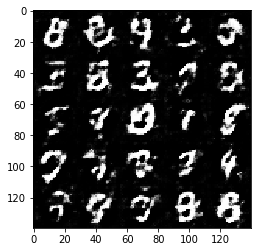

Epoch 0/2, Image 12800/60000: Loss of discriminator: 0.8661, Loss of generator: 1.0389
Epoch 0/2, Image 13440/60000: Loss of discriminator: 0.8602, Loss of generator: 1.2407
Epoch 0/2, Image 14080/60000: Loss of discriminator: 0.6912, Loss of generator: 1.9210
Epoch 0/2, Image 14720/60000: Loss of discriminator: 0.7528, Loss of generator: 1.8872
Epoch 0/2, Image 15360/60000: Loss of discriminator: 0.8734, Loss of generator: 1.8167


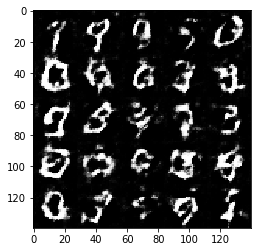

Epoch 0/2, Image 16000/60000: Loss of discriminator: 1.2491, Loss of generator: 2.2496
Epoch 0/2, Image 16640/60000: Loss of discriminator: 0.8158, Loss of generator: 1.1553
Epoch 0/2, Image 17280/60000: Loss of discriminator: 0.7339, Loss of generator: 1.3884
Epoch 0/2, Image 17920/60000: Loss of discriminator: 0.8002, Loss of generator: 1.5854
Epoch 0/2, Image 18560/60000: Loss of discriminator: 0.8073, Loss of generator: 1.4797


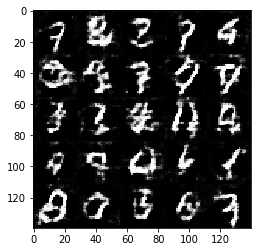

Epoch 0/2, Image 19200/60000: Loss of discriminator: 1.4499, Loss of generator: 0.4547
Epoch 0/2, Image 19840/60000: Loss of discriminator: 0.7515, Loss of generator: 1.4500
Epoch 0/2, Image 20480/60000: Loss of discriminator: 0.8528, Loss of generator: 1.3385
Epoch 0/2, Image 21120/60000: Loss of discriminator: 0.8887, Loss of generator: 1.1017
Epoch 0/2, Image 21760/60000: Loss of discriminator: 1.0784, Loss of generator: 0.7531


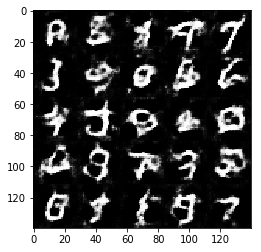

Epoch 0/2, Image 22400/60000: Loss of discriminator: 0.7888, Loss of generator: 1.5094
Epoch 0/2, Image 23040/60000: Loss of discriminator: 1.2677, Loss of generator: 0.5722
Epoch 0/2, Image 23680/60000: Loss of discriminator: 0.9324, Loss of generator: 1.1773
Epoch 0/2, Image 24320/60000: Loss of discriminator: 0.9196, Loss of generator: 1.0921
Epoch 0/2, Image 24960/60000: Loss of discriminator: 1.1381, Loss of generator: 0.7918


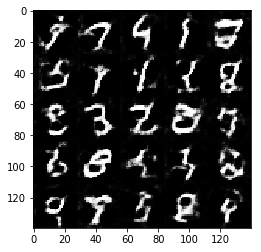

Epoch 0/2, Image 25600/60000: Loss of discriminator: 1.0000, Loss of generator: 1.0254
Epoch 0/2, Image 26240/60000: Loss of discriminator: 0.8823, Loss of generator: 1.1286
Epoch 0/2, Image 26880/60000: Loss of discriminator: 0.9067, Loss of generator: 1.0638
Epoch 0/2, Image 27520/60000: Loss of discriminator: 1.3396, Loss of generator: 0.5888
Epoch 0/2, Image 28160/60000: Loss of discriminator: 0.8818, Loss of generator: 1.3073


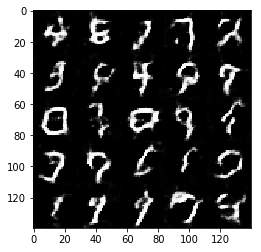

Epoch 0/2, Image 28800/60000: Loss of discriminator: 1.1197, Loss of generator: 0.7069
Epoch 0/2, Image 29440/60000: Loss of discriminator: 0.8339, Loss of generator: 1.4432
Epoch 0/2, Image 30080/60000: Loss of discriminator: 1.0397, Loss of generator: 1.6296
Epoch 0/2, Image 30720/60000: Loss of discriminator: 0.9419, Loss of generator: 1.4054
Epoch 0/2, Image 31360/60000: Loss of discriminator: 0.9383, Loss of generator: 1.0633


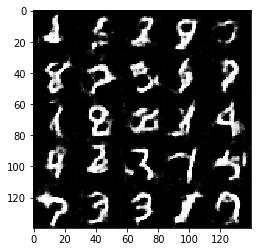

Epoch 0/2, Image 32000/60000: Loss of discriminator: 0.9166, Loss of generator: 1.3454
Epoch 0/2, Image 32640/60000: Loss of discriminator: 0.8837, Loss of generator: 1.4733
Epoch 0/2, Image 33280/60000: Loss of discriminator: 0.9337, Loss of generator: 1.0339
Epoch 0/2, Image 33920/60000: Loss of discriminator: 0.9190, Loss of generator: 1.1054
Epoch 0/2, Image 34560/60000: Loss of discriminator: 1.0064, Loss of generator: 0.9296


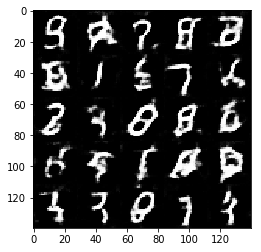

Epoch 0/2, Image 35200/60000: Loss of discriminator: 1.0658, Loss of generator: 0.8200
Epoch 0/2, Image 35840/60000: Loss of discriminator: 0.9524, Loss of generator: 1.5180
Epoch 0/2, Image 36480/60000: Loss of discriminator: 1.1780, Loss of generator: 2.1407
Epoch 0/2, Image 37120/60000: Loss of discriminator: 0.9575, Loss of generator: 1.0332
Epoch 0/2, Image 37760/60000: Loss of discriminator: 1.1253, Loss of generator: 2.1072


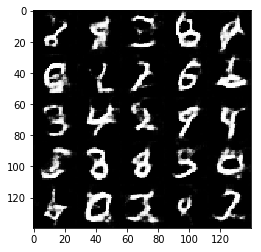

Epoch 0/2, Image 38400/60000: Loss of discriminator: 0.9406, Loss of generator: 1.0656
Epoch 0/2, Image 39040/60000: Loss of discriminator: 1.0437, Loss of generator: 0.8286
Epoch 0/2, Image 39680/60000: Loss of discriminator: 0.7930, Loss of generator: 1.4431
Epoch 0/2, Image 40320/60000: Loss of discriminator: 0.9583, Loss of generator: 0.9663
Epoch 0/2, Image 40960/60000: Loss of discriminator: 0.8686, Loss of generator: 1.4315


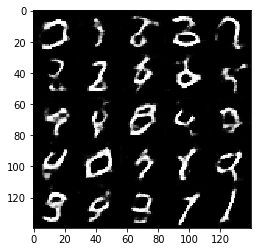

Epoch 0/2, Image 41600/60000: Loss of discriminator: 0.8098, Loss of generator: 1.7079
Epoch 0/2, Image 42240/60000: Loss of discriminator: 0.9906, Loss of generator: 1.3561
Epoch 0/2, Image 42880/60000: Loss of discriminator: 1.2420, Loss of generator: 0.6071
Epoch 0/2, Image 43520/60000: Loss of discriminator: 1.0436, Loss of generator: 0.8526
Epoch 0/2, Image 44160/60000: Loss of discriminator: 0.7712, Loss of generator: 1.2871


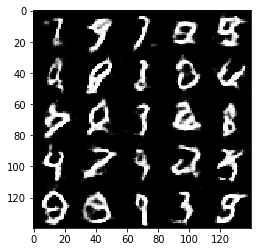

Epoch 0/2, Image 44800/60000: Loss of discriminator: 1.0120, Loss of generator: 0.8965
Epoch 0/2, Image 45440/60000: Loss of discriminator: 0.7303, Loss of generator: 1.4598
Epoch 0/2, Image 46080/60000: Loss of discriminator: 1.2246, Loss of generator: 0.6768
Epoch 0/2, Image 46720/60000: Loss of discriminator: 0.9518, Loss of generator: 1.2563
Epoch 0/2, Image 47360/60000: Loss of discriminator: 0.9699, Loss of generator: 0.9134


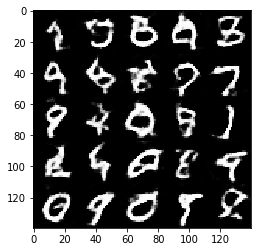

Epoch 0/2, Image 48000/60000: Loss of discriminator: 0.7674, Loss of generator: 1.2678
Epoch 0/2, Image 48640/60000: Loss of discriminator: 0.8392, Loss of generator: 1.1578
Epoch 0/2, Image 49280/60000: Loss of discriminator: 0.8035, Loss of generator: 1.1620
Epoch 0/2, Image 49920/60000: Loss of discriminator: 0.8449, Loss of generator: 2.3083
Epoch 0/2, Image 50560/60000: Loss of discriminator: 0.9159, Loss of generator: 0.9934


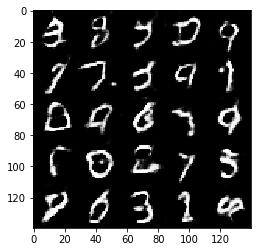

Epoch 0/2, Image 51200/60000: Loss of discriminator: 0.9631, Loss of generator: 0.9309
Epoch 0/2, Image 51840/60000: Loss of discriminator: 0.9717, Loss of generator: 0.9017
Epoch 0/2, Image 52480/60000: Loss of discriminator: 0.7922, Loss of generator: 1.3489
Epoch 0/2, Image 53120/60000: Loss of discriminator: 0.7821, Loss of generator: 1.3648
Epoch 0/2, Image 53760/60000: Loss of discriminator: 0.7815, Loss of generator: 1.2816


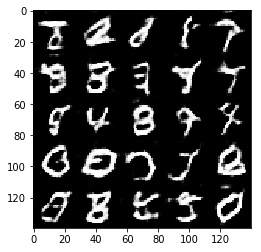

Epoch 0/2, Image 54400/60000: Loss of discriminator: 0.9363, Loss of generator: 0.9538
Epoch 0/2, Image 55040/60000: Loss of discriminator: 0.8748, Loss of generator: 1.0544
Epoch 0/2, Image 55680/60000: Loss of discriminator: 0.6520, Loss of generator: 1.7907
Epoch 0/2, Image 56320/60000: Loss of discriminator: 1.0593, Loss of generator: 0.7709
Epoch 0/2, Image 56960/60000: Loss of discriminator: 0.8147, Loss of generator: 1.3382


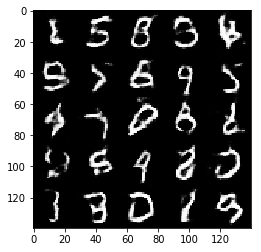

Epoch 0/2, Image 57600/60000: Loss of discriminator: 1.0553, Loss of generator: 0.8996
Epoch 0/2, Image 58240/60000: Loss of discriminator: 1.0263, Loss of generator: 0.8094
Epoch 0/2, Image 58880/60000: Loss of discriminator: 0.6674, Loss of generator: 1.6207
Epoch 0/2, Image 59520/60000: Loss of discriminator: 1.0042, Loss of generator: 0.8652
Epoch 1/2, Image 640/60000: Loss of discriminator: 0.7209, Loss of generator: 1.5369
Epoch 1/2, Image 1280/60000: Loss of discriminator: 0.8460, Loss of generator: 1.0762
Epoch 1/2, Image 1920/60000: Loss of discriminator: 0.6867, Loss of generator: 1.4672
Epoch 1/2, Image 2560/60000: Loss of discriminator: 0.8471, Loss of generator: 1.0457


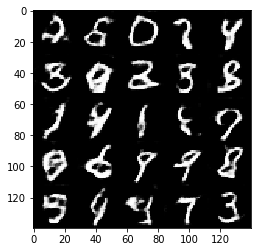

Epoch 1/2, Image 3200/60000: Loss of discriminator: 0.9292, Loss of generator: 0.9191
Epoch 1/2, Image 3840/60000: Loss of discriminator: 0.7187, Loss of generator: 1.7601
Epoch 1/2, Image 4480/60000: Loss of discriminator: 0.7870, Loss of generator: 1.1756
Epoch 1/2, Image 5120/60000: Loss of discriminator: 0.8245, Loss of generator: 1.6490
Epoch 1/2, Image 5760/60000: Loss of discriminator: 0.7480, Loss of generator: 1.3600


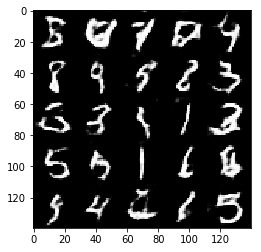

Epoch 1/2, Image 6400/60000: Loss of discriminator: 0.8720, Loss of generator: 1.0638
Epoch 1/2, Image 7040/60000: Loss of discriminator: 0.8261, Loss of generator: 2.4145
Epoch 1/2, Image 7680/60000: Loss of discriminator: 0.7981, Loss of generator: 1.2137
Epoch 1/2, Image 8320/60000: Loss of discriminator: 0.9307, Loss of generator: 0.9737
Epoch 1/2, Image 8960/60000: Loss of discriminator: 0.6733, Loss of generator: 1.5182


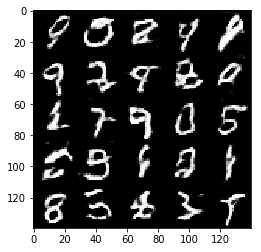

Epoch 1/2, Image 9600/60000: Loss of discriminator: 1.4313, Loss of generator: 0.4876
Epoch 1/2, Image 10240/60000: Loss of discriminator: 0.7793, Loss of generator: 1.4472
Epoch 1/2, Image 10880/60000: Loss of discriminator: 0.7490, Loss of generator: 1.4174
Epoch 1/2, Image 11520/60000: Loss of discriminator: 0.8424, Loss of generator: 1.1191
Epoch 1/2, Image 12160/60000: Loss of discriminator: 0.7523, Loss of generator: 1.5677


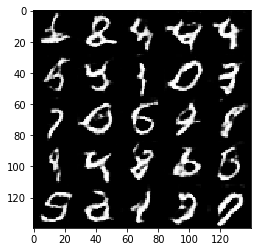

Epoch 1/2, Image 12800/60000: Loss of discriminator: 0.8981, Loss of generator: 0.9622
Epoch 1/2, Image 13440/60000: Loss of discriminator: 1.1993, Loss of generator: 0.6807
Epoch 1/2, Image 14080/60000: Loss of discriminator: 0.8572, Loss of generator: 1.0243
Epoch 1/2, Image 14720/60000: Loss of discriminator: 0.7131, Loss of generator: 1.6373
Epoch 1/2, Image 15360/60000: Loss of discriminator: 0.9325, Loss of generator: 0.9988


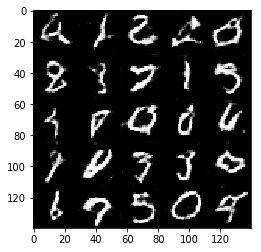

Epoch 1/2, Image 16000/60000: Loss of discriminator: 0.9956, Loss of generator: 0.8830
Epoch 1/2, Image 16640/60000: Loss of discriminator: 0.8077, Loss of generator: 1.1711
Epoch 1/2, Image 17280/60000: Loss of discriminator: 0.8855, Loss of generator: 1.0527
Epoch 1/2, Image 17920/60000: Loss of discriminator: 0.6317, Loss of generator: 1.6664
Epoch 1/2, Image 18560/60000: Loss of discriminator: 0.7905, Loss of generator: 2.0322


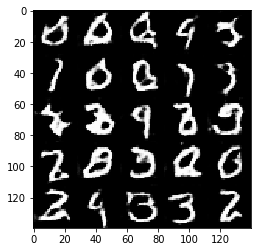

Epoch 1/2, Image 19200/60000: Loss of discriminator: 0.7542, Loss of generator: 1.2998
Epoch 1/2, Image 19840/60000: Loss of discriminator: 1.4002, Loss of generator: 0.5689
Epoch 1/2, Image 20480/60000: Loss of discriminator: 0.8598, Loss of generator: 1.0768
Epoch 1/2, Image 21120/60000: Loss of discriminator: 0.6830, Loss of generator: 1.6356
Epoch 1/2, Image 21760/60000: Loss of discriminator: 0.6823, Loss of generator: 1.7839


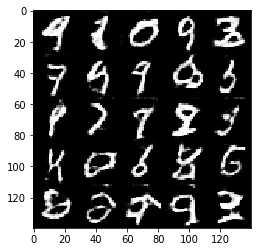

Epoch 1/2, Image 22400/60000: Loss of discriminator: 0.7223, Loss of generator: 1.4957
Epoch 1/2, Image 23040/60000: Loss of discriminator: 1.2958, Loss of generator: 0.5360
Epoch 1/2, Image 23680/60000: Loss of discriminator: 0.8449, Loss of generator: 1.1379
Epoch 1/2, Image 24320/60000: Loss of discriminator: 0.9443, Loss of generator: 0.9486
Epoch 1/2, Image 24960/60000: Loss of discriminator: 1.0043, Loss of generator: 0.8050


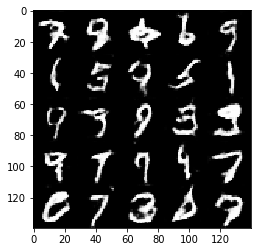

Epoch 1/2, Image 25600/60000: Loss of discriminator: 0.8226, Loss of generator: 1.1562
Epoch 1/2, Image 26240/60000: Loss of discriminator: 0.6033, Loss of generator: 1.6562
Epoch 1/2, Image 26880/60000: Loss of discriminator: 0.8161, Loss of generator: 1.1162
Epoch 1/2, Image 27520/60000: Loss of discriminator: 1.0641, Loss of generator: 0.7757
Epoch 1/2, Image 28160/60000: Loss of discriminator: 0.7276, Loss of generator: 1.9990


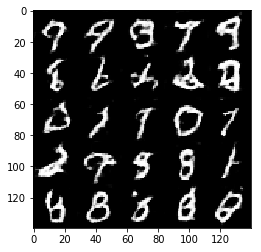

Epoch 1/2, Image 28800/60000: Loss of discriminator: 0.8287, Loss of generator: 1.2436
Epoch 1/2, Image 29440/60000: Loss of discriminator: 0.6371, Loss of generator: 1.8539
Epoch 1/2, Image 30080/60000: Loss of discriminator: 0.7325, Loss of generator: 1.3103
Epoch 1/2, Image 30720/60000: Loss of discriminator: 0.6292, Loss of generator: 1.6484
Epoch 1/2, Image 31360/60000: Loss of discriminator: 1.2545, Loss of generator: 0.6246


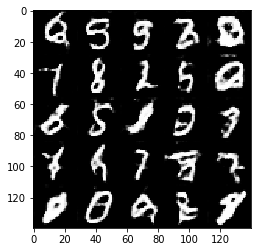

Epoch 1/2, Image 32000/60000: Loss of discriminator: 0.8389, Loss of generator: 1.2959
Epoch 1/2, Image 32640/60000: Loss of discriminator: 0.7319, Loss of generator: 1.3771
Epoch 1/2, Image 33280/60000: Loss of discriminator: 0.7139, Loss of generator: 2.0279
Epoch 1/2, Image 33920/60000: Loss of discriminator: 0.7627, Loss of generator: 1.2510
Epoch 1/2, Image 34560/60000: Loss of discriminator: 0.6928, Loss of generator: 1.5316


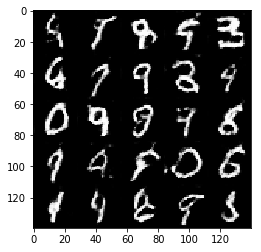

Epoch 1/2, Image 35200/60000: Loss of discriminator: 0.8241, Loss of generator: 1.1850
Epoch 1/2, Image 35840/60000: Loss of discriminator: 0.6143, Loss of generator: 1.9610
Epoch 1/2, Image 36480/60000: Loss of discriminator: 0.7395, Loss of generator: 1.4794
Epoch 1/2, Image 37120/60000: Loss of discriminator: 0.6938, Loss of generator: 1.4535
Epoch 1/2, Image 37760/60000: Loss of discriminator: 0.8671, Loss of generator: 1.7709


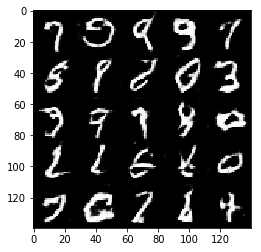

Epoch 1/2, Image 38400/60000: Loss of discriminator: 0.6670, Loss of generator: 1.7676
Epoch 1/2, Image 39040/60000: Loss of discriminator: 0.7474, Loss of generator: 1.2868
Epoch 1/2, Image 39680/60000: Loss of discriminator: 0.6359, Loss of generator: 1.5563
Epoch 1/2, Image 40320/60000: Loss of discriminator: 0.6373, Loss of generator: 1.5500
Epoch 1/2, Image 40960/60000: Loss of discriminator: 0.6965, Loss of generator: 1.7317


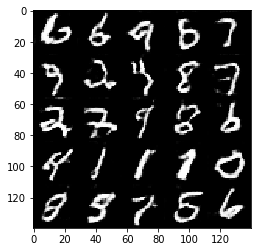

Epoch 1/2, Image 41600/60000: Loss of discriminator: 0.7273, Loss of generator: 1.4092
Epoch 1/2, Image 42240/60000: Loss of discriminator: 0.7427, Loss of generator: 1.5161
Epoch 1/2, Image 42880/60000: Loss of discriminator: 0.9471, Loss of generator: 0.9432
Epoch 1/2, Image 43520/60000: Loss of discriminator: 0.7874, Loss of generator: 1.1450
Epoch 1/2, Image 44160/60000: Loss of discriminator: 0.5761, Loss of generator: 2.0056


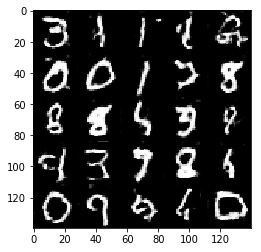

Epoch 1/2, Image 44800/60000: Loss of discriminator: 0.8472, Loss of generator: 1.9751
Epoch 1/2, Image 45440/60000: Loss of discriminator: 0.5128, Loss of generator: 2.3525
Epoch 1/2, Image 46080/60000: Loss of discriminator: 1.2418, Loss of generator: 0.6479
Epoch 1/2, Image 46720/60000: Loss of discriminator: 0.7438, Loss of generator: 1.4406
Epoch 1/2, Image 47360/60000: Loss of discriminator: 0.9830, Loss of generator: 0.8910


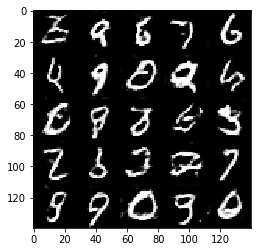

Epoch 1/2, Image 48000/60000: Loss of discriminator: 0.7841, Loss of generator: 1.2746
Epoch 1/2, Image 48640/60000: Loss of discriminator: 0.6533, Loss of generator: 1.4820
Epoch 1/2, Image 49280/60000: Loss of discriminator: 0.7167, Loss of generator: 1.3998
Epoch 1/2, Image 49920/60000: Loss of discriminator: 0.6187, Loss of generator: 1.9826
Epoch 1/2, Image 50560/60000: Loss of discriminator: 1.1733, Loss of generator: 0.7549


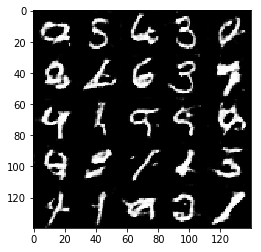

Epoch 1/2, Image 51200/60000: Loss of discriminator: 0.6932, Loss of generator: 1.4393
Epoch 1/2, Image 51840/60000: Loss of discriminator: 0.8148, Loss of generator: 1.2485
Epoch 1/2, Image 52480/60000: Loss of discriminator: 0.6795, Loss of generator: 1.5507
Epoch 1/2, Image 53120/60000: Loss of discriminator: 0.6134, Loss of generator: 1.8453
Epoch 1/2, Image 53760/60000: Loss of discriminator: 0.6773, Loss of generator: 1.4625


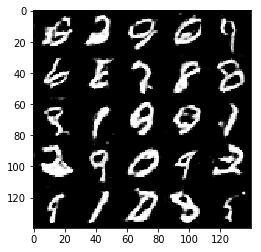

Epoch 1/2, Image 54400/60000: Loss of discriminator: 0.8069, Loss of generator: 1.1503
Epoch 1/2, Image 55040/60000: Loss of discriminator: 0.8918, Loss of generator: 1.0155
Epoch 1/2, Image 55680/60000: Loss of discriminator: 0.7289, Loss of generator: 2.0035
Epoch 1/2, Image 56320/60000: Loss of discriminator: 0.8117, Loss of generator: 1.2157
Epoch 1/2, Image 56960/60000: Loss of discriminator: 0.6728, Loss of generator: 1.9421


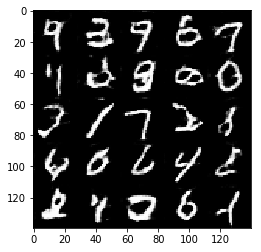

Epoch 1/2, Image 57600/60000: Loss of discriminator: 0.6848, Loss of generator: 1.4339
Epoch 1/2, Image 58240/60000: Loss of discriminator: 0.7657, Loss of generator: 1.2125
Epoch 1/2, Image 58880/60000: Loss of discriminator: 0.5567, Loss of generator: 1.9738
Epoch 1/2, Image 59520/60000: Loss of discriminator: 0.7178, Loss of generator: 1.7275


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1, Image 640/202599: Loss of discriminator: 0.8467, Loss of generator: 1.1156
Epoch 0/1, Image 1280/202599: Loss of discriminator: 0.6558, Loss of generator: 1.5126
Epoch 0/1, Image 1920/202599: Loss of discriminator: 0.5936, Loss of generator: 2.3245
Epoch 0/1, Image 2560/202599: Loss of discriminator: 0.7786, Loss of generator: 1.3350


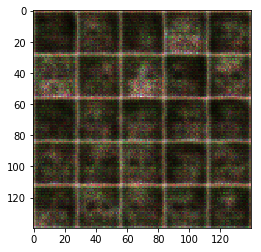

Epoch 0/1, Image 3200/202599: Loss of discriminator: 0.6491, Loss of generator: 1.7196
Epoch 0/1, Image 3840/202599: Loss of discriminator: 0.6226, Loss of generator: 2.2632
Epoch 0/1, Image 4480/202599: Loss of discriminator: 1.0365, Loss of generator: 0.8305
Epoch 0/1, Image 5120/202599: Loss of discriminator: 1.4161, Loss of generator: 0.5171
Epoch 0/1, Image 5760/202599: Loss of discriminator: 0.6759, Loss of generator: 1.6530


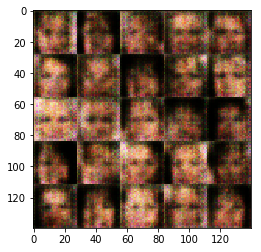

Epoch 0/1, Image 6400/202599: Loss of discriminator: 0.9358, Loss of generator: 1.0293
Epoch 0/1, Image 7040/202599: Loss of discriminator: 0.6279, Loss of generator: 1.7747
Epoch 0/1, Image 7680/202599: Loss of discriminator: 1.1248, Loss of generator: 0.7435
Epoch 0/1, Image 8320/202599: Loss of discriminator: 0.8316, Loss of generator: 1.1405
Epoch 0/1, Image 8960/202599: Loss of discriminator: 0.9134, Loss of generator: 1.0548


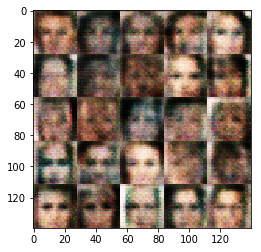

Epoch 0/1, Image 9600/202599: Loss of discriminator: 0.7218, Loss of generator: 1.5617
Epoch 0/1, Image 10240/202599: Loss of discriminator: 0.7509, Loss of generator: 1.7711
Epoch 0/1, Image 10880/202599: Loss of discriminator: 0.9304, Loss of generator: 1.2884
Epoch 0/1, Image 11520/202599: Loss of discriminator: 0.9729, Loss of generator: 1.0603
Epoch 0/1, Image 12160/202599: Loss of discriminator: 0.6878, Loss of generator: 2.3286


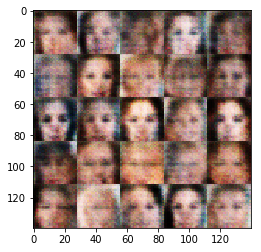

Epoch 0/1, Image 12800/202599: Loss of discriminator: 0.8797, Loss of generator: 1.4855
Epoch 0/1, Image 13440/202599: Loss of discriminator: 0.6406, Loss of generator: 1.7665
Epoch 0/1, Image 14080/202599: Loss of discriminator: 0.7528, Loss of generator: 1.3716
Epoch 0/1, Image 14720/202599: Loss of discriminator: 0.8552, Loss of generator: 1.3196
Epoch 0/1, Image 15360/202599: Loss of discriminator: 1.1488, Loss of generator: 0.8290


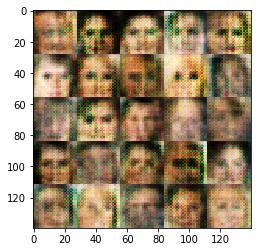

Epoch 0/1, Image 16000/202599: Loss of discriminator: 1.1087, Loss of generator: 1.3297
Epoch 0/1, Image 16640/202599: Loss of discriminator: 1.0440, Loss of generator: 0.8904
Epoch 0/1, Image 17280/202599: Loss of discriminator: 0.9216, Loss of generator: 1.2096
Epoch 0/1, Image 17920/202599: Loss of discriminator: 1.0659, Loss of generator: 1.0605
Epoch 0/1, Image 18560/202599: Loss of discriminator: 0.9568, Loss of generator: 1.0503


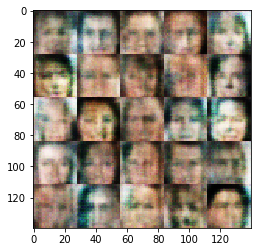

Epoch 0/1, Image 19200/202599: Loss of discriminator: 1.1317, Loss of generator: 0.8493
Epoch 0/1, Image 19840/202599: Loss of discriminator: 1.0696, Loss of generator: 1.0596
Epoch 0/1, Image 20480/202599: Loss of discriminator: 1.2600, Loss of generator: 0.6270
Epoch 0/1, Image 21120/202599: Loss of discriminator: 1.0039, Loss of generator: 1.4702
Epoch 0/1, Image 21760/202599: Loss of discriminator: 1.0993, Loss of generator: 0.9830


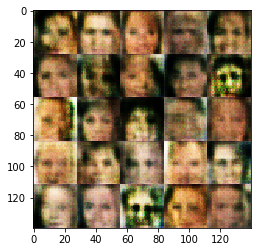

Epoch 0/1, Image 22400/202599: Loss of discriminator: 0.9930, Loss of generator: 1.3004
Epoch 0/1, Image 23040/202599: Loss of discriminator: 1.0863, Loss of generator: 0.9906
Epoch 0/1, Image 23680/202599: Loss of discriminator: 1.0809, Loss of generator: 0.9046
Epoch 0/1, Image 24320/202599: Loss of discriminator: 1.0556, Loss of generator: 1.0468
Epoch 0/1, Image 24960/202599: Loss of discriminator: 1.2035, Loss of generator: 1.1690


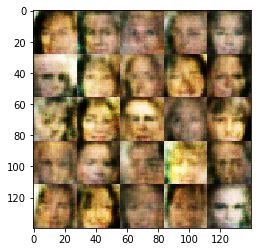

Epoch 0/1, Image 25600/202599: Loss of discriminator: 1.0596, Loss of generator: 0.9632
Epoch 0/1, Image 26240/202599: Loss of discriminator: 1.1276, Loss of generator: 1.0784
Epoch 0/1, Image 26880/202599: Loss of discriminator: 1.2058, Loss of generator: 0.9555
Epoch 0/1, Image 27520/202599: Loss of discriminator: 1.0479, Loss of generator: 1.1293
Epoch 0/1, Image 28160/202599: Loss of discriminator: 1.2114, Loss of generator: 0.7045


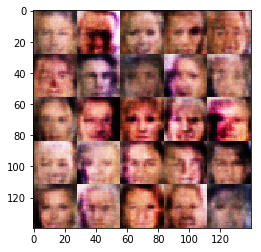

Epoch 0/1, Image 28800/202599: Loss of discriminator: 0.9586, Loss of generator: 1.0540
Epoch 0/1, Image 29440/202599: Loss of discriminator: 1.0336, Loss of generator: 1.0260
Epoch 0/1, Image 30080/202599: Loss of discriminator: 1.0281, Loss of generator: 1.2505
Epoch 0/1, Image 30720/202599: Loss of discriminator: 1.0178, Loss of generator: 1.4898
Epoch 0/1, Image 31360/202599: Loss of discriminator: 1.0753, Loss of generator: 0.9531


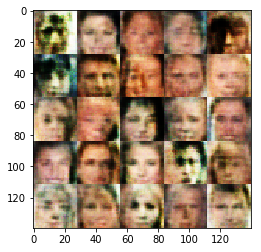

Epoch 0/1, Image 32000/202599: Loss of discriminator: 1.1955, Loss of generator: 0.8124
Epoch 0/1, Image 32640/202599: Loss of discriminator: 1.1754, Loss of generator: 0.8130
Epoch 0/1, Image 33280/202599: Loss of discriminator: 1.2170, Loss of generator: 0.7612
Epoch 0/1, Image 33920/202599: Loss of discriminator: 1.1059, Loss of generator: 0.8836
Epoch 0/1, Image 34560/202599: Loss of discriminator: 1.0494, Loss of generator: 1.0117


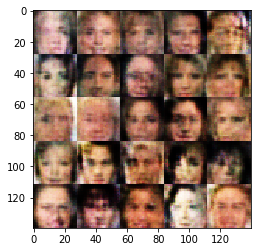

Epoch 0/1, Image 35200/202599: Loss of discriminator: 1.1857, Loss of generator: 0.9625
Epoch 0/1, Image 35840/202599: Loss of discriminator: 1.0477, Loss of generator: 1.6233
Epoch 0/1, Image 36480/202599: Loss of discriminator: 1.0843, Loss of generator: 0.9385
Epoch 0/1, Image 37120/202599: Loss of discriminator: 1.0715, Loss of generator: 1.3760
Epoch 0/1, Image 37760/202599: Loss of discriminator: 1.0464, Loss of generator: 0.9901


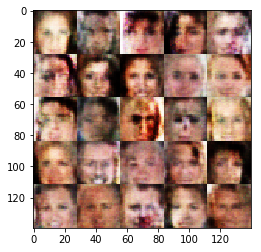

Epoch 0/1, Image 38400/202599: Loss of discriminator: 1.0413, Loss of generator: 0.9467
Epoch 0/1, Image 39040/202599: Loss of discriminator: 1.0868, Loss of generator: 1.1253
Epoch 0/1, Image 39680/202599: Loss of discriminator: 1.0442, Loss of generator: 0.9799
Epoch 0/1, Image 40320/202599: Loss of discriminator: 1.1893, Loss of generator: 0.8796
Epoch 0/1, Image 40960/202599: Loss of discriminator: 1.2142, Loss of generator: 0.9169


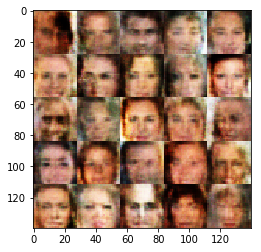

Epoch 0/1, Image 41600/202599: Loss of discriminator: 1.0007, Loss of generator: 0.8867
Epoch 0/1, Image 42240/202599: Loss of discriminator: 1.0869, Loss of generator: 1.0181
Epoch 0/1, Image 42880/202599: Loss of discriminator: 1.1240, Loss of generator: 0.9480
Epoch 0/1, Image 43520/202599: Loss of discriminator: 1.0912, Loss of generator: 0.8968
Epoch 0/1, Image 44160/202599: Loss of discriminator: 0.8744, Loss of generator: 1.1660


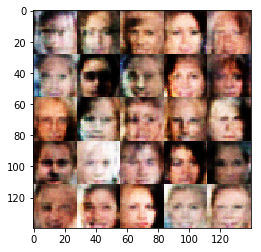

Epoch 0/1, Image 44800/202599: Loss of discriminator: 1.4382, Loss of generator: 0.4703
Epoch 0/1, Image 45440/202599: Loss of discriminator: 1.0122, Loss of generator: 1.2408
Epoch 0/1, Image 46080/202599: Loss of discriminator: 1.3183, Loss of generator: 0.5530
Epoch 0/1, Image 46720/202599: Loss of discriminator: 1.1227, Loss of generator: 1.0107
Epoch 0/1, Image 47360/202599: Loss of discriminator: 1.0406, Loss of generator: 0.8839


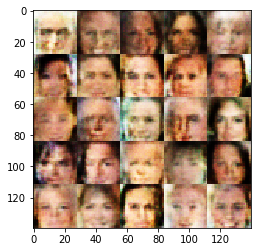

Epoch 0/1, Image 48000/202599: Loss of discriminator: 1.0177, Loss of generator: 1.3732
Epoch 0/1, Image 48640/202599: Loss of discriminator: 1.0374, Loss of generator: 1.0573
Epoch 0/1, Image 49280/202599: Loss of discriminator: 1.3617, Loss of generator: 0.5816
Epoch 0/1, Image 49920/202599: Loss of discriminator: 1.1423, Loss of generator: 0.7957
Epoch 0/1, Image 50560/202599: Loss of discriminator: 1.1002, Loss of generator: 0.9821


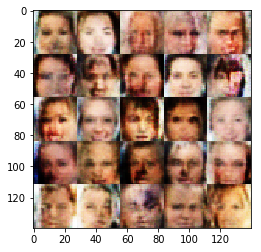

Epoch 0/1, Image 51200/202599: Loss of discriminator: 1.2836, Loss of generator: 0.6293
Epoch 0/1, Image 51840/202599: Loss of discriminator: 1.4447, Loss of generator: 1.0723
Epoch 0/1, Image 52480/202599: Loss of discriminator: 1.1198, Loss of generator: 1.0339
Epoch 0/1, Image 53120/202599: Loss of discriminator: 0.9116, Loss of generator: 1.2555
Epoch 0/1, Image 53760/202599: Loss of discriminator: 0.9209, Loss of generator: 1.2287


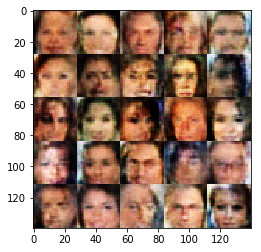

Epoch 0/1, Image 54400/202599: Loss of discriminator: 1.1471, Loss of generator: 0.7882
Epoch 0/1, Image 55040/202599: Loss of discriminator: 1.0897, Loss of generator: 0.8608
Epoch 0/1, Image 55680/202599: Loss of discriminator: 1.2062, Loss of generator: 0.6688
Epoch 0/1, Image 56320/202599: Loss of discriminator: 0.8914, Loss of generator: 1.3944
Epoch 0/1, Image 56960/202599: Loss of discriminator: 1.0316, Loss of generator: 0.9447


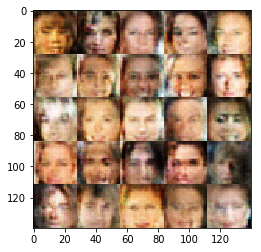

Epoch 0/1, Image 57600/202599: Loss of discriminator: 1.0722, Loss of generator: 0.9013
Epoch 0/1, Image 58240/202599: Loss of discriminator: 1.0447, Loss of generator: 0.9732
Epoch 0/1, Image 58880/202599: Loss of discriminator: 1.1037, Loss of generator: 0.8767
Epoch 0/1, Image 59520/202599: Loss of discriminator: 1.1600, Loss of generator: 0.6631
Epoch 0/1, Image 60160/202599: Loss of discriminator: 1.0389, Loss of generator: 1.0629


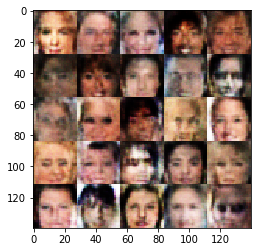

Epoch 0/1, Image 60800/202599: Loss of discriminator: 1.0226, Loss of generator: 0.9929
Epoch 0/1, Image 61440/202599: Loss of discriminator: 1.1070, Loss of generator: 0.8321
Epoch 0/1, Image 62080/202599: Loss of discriminator: 1.4747, Loss of generator: 0.5054
Epoch 0/1, Image 62720/202599: Loss of discriminator: 1.2173, Loss of generator: 0.6736
Epoch 0/1, Image 63360/202599: Loss of discriminator: 0.9784, Loss of generator: 1.0470


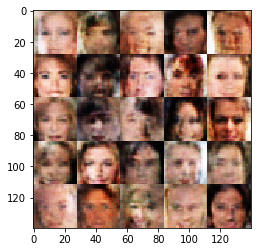

Epoch 0/1, Image 64000/202599: Loss of discriminator: 1.2960, Loss of generator: 0.5939
Epoch 0/1, Image 64640/202599: Loss of discriminator: 1.2710, Loss of generator: 0.8607
Epoch 0/1, Image 65280/202599: Loss of discriminator: 0.9470, Loss of generator: 1.1032
Epoch 0/1, Image 65920/202599: Loss of discriminator: 1.3254, Loss of generator: 0.5377
Epoch 0/1, Image 66560/202599: Loss of discriminator: 0.9781, Loss of generator: 1.0199


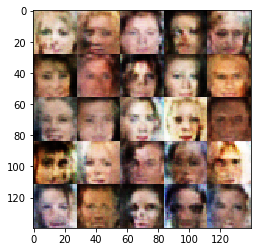

Epoch 0/1, Image 67200/202599: Loss of discriminator: 1.0832, Loss of generator: 1.0780
Epoch 0/1, Image 67840/202599: Loss of discriminator: 1.1736, Loss of generator: 0.8104
Epoch 0/1, Image 68480/202599: Loss of discriminator: 0.9547, Loss of generator: 1.2800
Epoch 0/1, Image 69120/202599: Loss of discriminator: 1.0888, Loss of generator: 1.3554
Epoch 0/1, Image 69760/202599: Loss of discriminator: 1.2224, Loss of generator: 0.6125


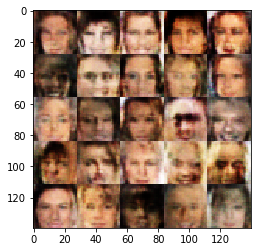

Epoch 0/1, Image 70400/202599: Loss of discriminator: 1.2390, Loss of generator: 1.3533
Epoch 0/1, Image 71040/202599: Loss of discriminator: 0.9700, Loss of generator: 1.0933
Epoch 0/1, Image 71680/202599: Loss of discriminator: 0.6946, Loss of generator: 1.8142
Epoch 0/1, Image 72320/202599: Loss of discriminator: 1.1018, Loss of generator: 0.9516
Epoch 0/1, Image 72960/202599: Loss of discriminator: 1.0687, Loss of generator: 0.8615


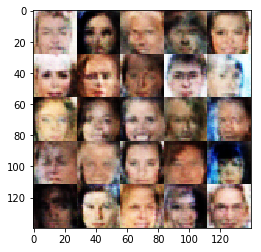

Epoch 0/1, Image 73600/202599: Loss of discriminator: 1.0369, Loss of generator: 1.0898
Epoch 0/1, Image 74240/202599: Loss of discriminator: 1.0079, Loss of generator: 1.0825
Epoch 0/1, Image 74880/202599: Loss of discriminator: 1.2909, Loss of generator: 0.5912
Epoch 0/1, Image 75520/202599: Loss of discriminator: 1.5225, Loss of generator: 0.4504
Epoch 0/1, Image 76160/202599: Loss of discriminator: 1.0596, Loss of generator: 1.0478


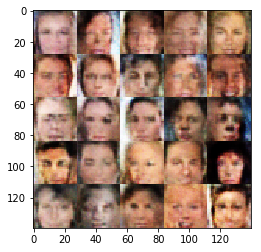

Epoch 0/1, Image 76800/202599: Loss of discriminator: 1.2317, Loss of generator: 0.6637
Epoch 0/1, Image 77440/202599: Loss of discriminator: 0.7963, Loss of generator: 1.4084
Epoch 0/1, Image 78080/202599: Loss of discriminator: 0.9979, Loss of generator: 1.0225
Epoch 0/1, Image 78720/202599: Loss of discriminator: 0.8652, Loss of generator: 1.2294
Epoch 0/1, Image 79360/202599: Loss of discriminator: 0.9678, Loss of generator: 0.9688


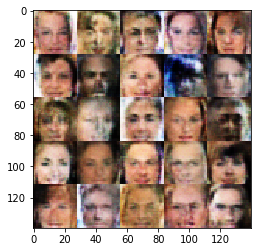

Epoch 0/1, Image 80000/202599: Loss of discriminator: 1.0154, Loss of generator: 0.9964
Epoch 0/1, Image 80640/202599: Loss of discriminator: 1.0380, Loss of generator: 1.1252
Epoch 0/1, Image 81280/202599: Loss of discriminator: 1.0883, Loss of generator: 0.8874
Epoch 0/1, Image 81920/202599: Loss of discriminator: 0.8662, Loss of generator: 1.4688
Epoch 0/1, Image 82560/202599: Loss of discriminator: 1.0012, Loss of generator: 1.2808


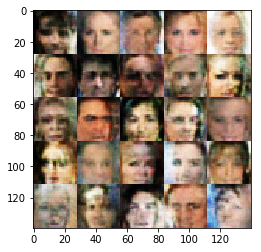

Epoch 0/1, Image 83200/202599: Loss of discriminator: 0.9042, Loss of generator: 1.0531
Epoch 0/1, Image 83840/202599: Loss of discriminator: 1.0296, Loss of generator: 1.1008
Epoch 0/1, Image 84480/202599: Loss of discriminator: 1.3817, Loss of generator: 0.5020
Epoch 0/1, Image 85120/202599: Loss of discriminator: 1.0661, Loss of generator: 1.4168
Epoch 0/1, Image 85760/202599: Loss of discriminator: 1.0267, Loss of generator: 0.9060


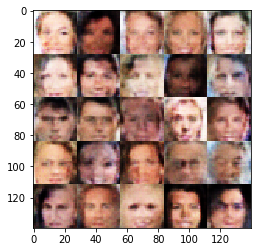

Epoch 0/1, Image 86400/202599: Loss of discriminator: 1.1287, Loss of generator: 0.9444
Epoch 0/1, Image 87040/202599: Loss of discriminator: 0.8885, Loss of generator: 1.2276
Epoch 0/1, Image 87680/202599: Loss of discriminator: 0.7875, Loss of generator: 1.2955
Epoch 0/1, Image 88320/202599: Loss of discriminator: 0.7619, Loss of generator: 1.4099
Epoch 0/1, Image 88960/202599: Loss of discriminator: 1.1075, Loss of generator: 0.9973


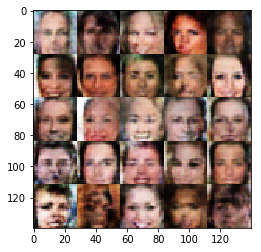

Epoch 0/1, Image 89600/202599: Loss of discriminator: 0.9580, Loss of generator: 1.1323
Epoch 0/1, Image 90240/202599: Loss of discriminator: 1.0655, Loss of generator: 1.0716
Epoch 0/1, Image 90880/202599: Loss of discriminator: 0.9754, Loss of generator: 0.9285
Epoch 0/1, Image 91520/202599: Loss of discriminator: 1.0915, Loss of generator: 0.8394
Epoch 0/1, Image 92160/202599: Loss of discriminator: 1.2781, Loss of generator: 0.6215


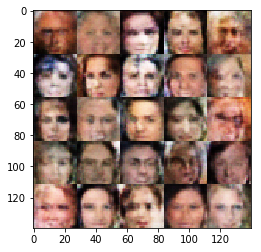

Epoch 0/1, Image 92800/202599: Loss of discriminator: 0.9459, Loss of generator: 1.0912
Epoch 0/1, Image 93440/202599: Loss of discriminator: 1.2061, Loss of generator: 0.7435
Epoch 0/1, Image 94080/202599: Loss of discriminator: 1.0503, Loss of generator: 1.1078
Epoch 0/1, Image 94720/202599: Loss of discriminator: 1.2435, Loss of generator: 0.7366
Epoch 0/1, Image 95360/202599: Loss of discriminator: 0.6811, Loss of generator: 1.8853


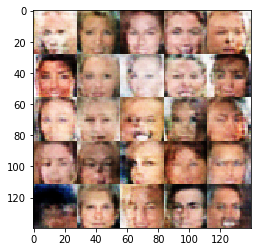

Epoch 0/1, Image 96000/202599: Loss of discriminator: 1.0857, Loss of generator: 0.8349
Epoch 0/1, Image 96640/202599: Loss of discriminator: 1.2390, Loss of generator: 0.6231
Epoch 0/1, Image 97280/202599: Loss of discriminator: 1.0345, Loss of generator: 0.8159
Epoch 0/1, Image 97920/202599: Loss of discriminator: 0.9653, Loss of generator: 1.3166
Epoch 0/1, Image 98560/202599: Loss of discriminator: 1.1775, Loss of generator: 1.0841


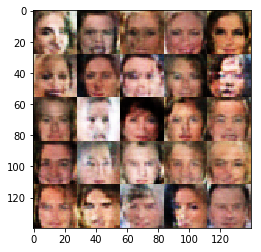

Epoch 0/1, Image 99200/202599: Loss of discriminator: 1.2638, Loss of generator: 0.7650
Epoch 0/1, Image 99840/202599: Loss of discriminator: 0.9949, Loss of generator: 1.3889
Epoch 0/1, Image 100480/202599: Loss of discriminator: 0.9700, Loss of generator: 1.0497
Epoch 0/1, Image 101120/202599: Loss of discriminator: 1.2229, Loss of generator: 0.7632
Epoch 0/1, Image 101760/202599: Loss of discriminator: 1.0280, Loss of generator: 1.0357


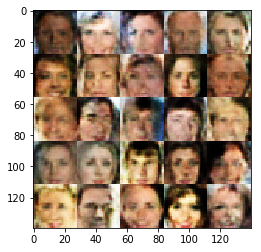

Epoch 0/1, Image 102400/202599: Loss of discriminator: 0.8953, Loss of generator: 1.1318
Epoch 0/1, Image 103040/202599: Loss of discriminator: 1.1590, Loss of generator: 0.9360
Epoch 0/1, Image 103680/202599: Loss of discriminator: 0.9787, Loss of generator: 1.1602
Epoch 0/1, Image 104320/202599: Loss of discriminator: 1.0555, Loss of generator: 0.9431
Epoch 0/1, Image 104960/202599: Loss of discriminator: 0.9238, Loss of generator: 1.0258


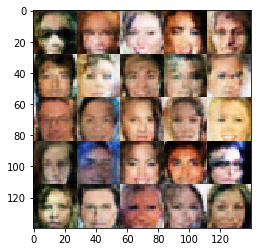

Epoch 0/1, Image 105600/202599: Loss of discriminator: 1.2302, Loss of generator: 0.7992
Epoch 0/1, Image 106240/202599: Loss of discriminator: 1.1455, Loss of generator: 0.8410
Epoch 0/1, Image 106880/202599: Loss of discriminator: 0.8285, Loss of generator: 1.9148
Epoch 0/1, Image 107520/202599: Loss of discriminator: 1.2963, Loss of generator: 0.7393
Epoch 0/1, Image 108160/202599: Loss of discriminator: 1.1597, Loss of generator: 0.8748


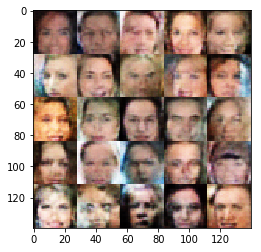

Epoch 0/1, Image 108800/202599: Loss of discriminator: 1.0697, Loss of generator: 0.9251
Epoch 0/1, Image 109440/202599: Loss of discriminator: 1.0863, Loss of generator: 0.8192
Epoch 0/1, Image 110080/202599: Loss of discriminator: 0.9747, Loss of generator: 1.0638
Epoch 0/1, Image 110720/202599: Loss of discriminator: 1.0602, Loss of generator: 0.9159
Epoch 0/1, Image 111360/202599: Loss of discriminator: 0.7896, Loss of generator: 1.6911


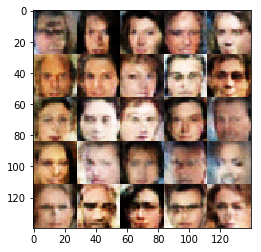

Epoch 0/1, Image 112000/202599: Loss of discriminator: 1.0047, Loss of generator: 0.9387
Epoch 0/1, Image 112640/202599: Loss of discriminator: 1.5723, Loss of generator: 0.3982
Epoch 0/1, Image 113280/202599: Loss of discriminator: 1.3851, Loss of generator: 0.5173
Epoch 0/1, Image 113920/202599: Loss of discriminator: 1.0060, Loss of generator: 0.9433
Epoch 0/1, Image 114560/202599: Loss of discriminator: 1.2465, Loss of generator: 0.7024


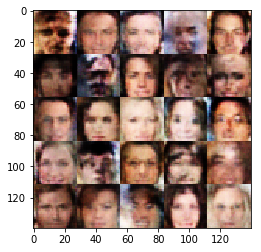

Epoch 0/1, Image 115200/202599: Loss of discriminator: 0.8281, Loss of generator: 1.3677
Epoch 0/1, Image 115840/202599: Loss of discriminator: 1.1027, Loss of generator: 0.8151
Epoch 0/1, Image 116480/202599: Loss of discriminator: 1.0921, Loss of generator: 1.0972
Epoch 0/1, Image 117120/202599: Loss of discriminator: 0.9889, Loss of generator: 0.9906
Epoch 0/1, Image 117760/202599: Loss of discriminator: 0.5984, Loss of generator: 1.7980


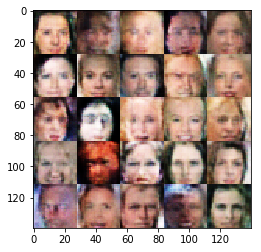

Epoch 0/1, Image 118400/202599: Loss of discriminator: 1.0422, Loss of generator: 0.9127
Epoch 0/1, Image 119040/202599: Loss of discriminator: 0.9996, Loss of generator: 1.1935
Epoch 0/1, Image 119680/202599: Loss of discriminator: 1.1283, Loss of generator: 0.8624
Epoch 0/1, Image 120320/202599: Loss of discriminator: 1.2964, Loss of generator: 0.6990
Epoch 0/1, Image 120960/202599: Loss of discriminator: 1.1096, Loss of generator: 0.7796


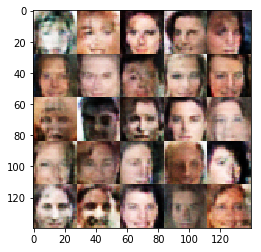

Epoch 0/1, Image 121600/202599: Loss of discriminator: 1.0369, Loss of generator: 0.9814
Epoch 0/1, Image 122240/202599: Loss of discriminator: 1.0975, Loss of generator: 0.9319
Epoch 0/1, Image 122880/202599: Loss of discriminator: 1.2723, Loss of generator: 0.7693
Epoch 0/1, Image 123520/202599: Loss of discriminator: 0.9701, Loss of generator: 1.3325
Epoch 0/1, Image 124160/202599: Loss of discriminator: 1.3310, Loss of generator: 0.5543


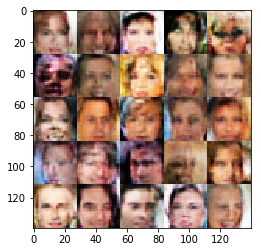

Epoch 0/1, Image 124800/202599: Loss of discriminator: 1.4090, Loss of generator: 0.5239
Epoch 0/1, Image 125440/202599: Loss of discriminator: 1.3540, Loss of generator: 0.5224
Epoch 0/1, Image 126080/202599: Loss of discriminator: 0.8872, Loss of generator: 1.3122
Epoch 0/1, Image 126720/202599: Loss of discriminator: 0.8772, Loss of generator: 1.3058
Epoch 0/1, Image 127360/202599: Loss of discriminator: 1.0038, Loss of generator: 0.8521


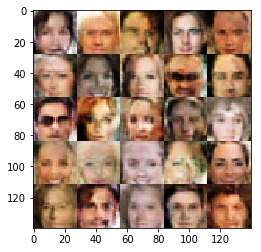

Epoch 0/1, Image 128000/202599: Loss of discriminator: 0.8822, Loss of generator: 1.0775
Epoch 0/1, Image 128640/202599: Loss of discriminator: 1.2455, Loss of generator: 0.6110
Epoch 0/1, Image 129280/202599: Loss of discriminator: 1.1073, Loss of generator: 0.8589
Epoch 0/1, Image 129920/202599: Loss of discriminator: 0.7457, Loss of generator: 1.5200
Epoch 0/1, Image 130560/202599: Loss of discriminator: 1.1541, Loss of generator: 1.3370


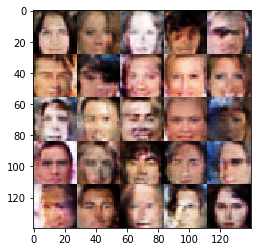

Epoch 0/1, Image 131200/202599: Loss of discriminator: 1.1405, Loss of generator: 0.8322
Epoch 0/1, Image 131840/202599: Loss of discriminator: 1.0655, Loss of generator: 0.7937
Epoch 0/1, Image 132480/202599: Loss of discriminator: 0.7015, Loss of generator: 1.5187
Epoch 0/1, Image 133120/202599: Loss of discriminator: 0.9966, Loss of generator: 0.9734
Epoch 0/1, Image 133760/202599: Loss of discriminator: 1.1952, Loss of generator: 0.7686


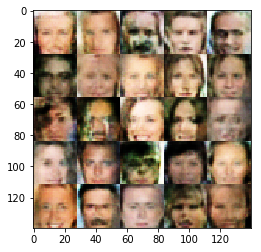

Epoch 0/1, Image 134400/202599: Loss of discriminator: 0.9760, Loss of generator: 0.9698
Epoch 0/1, Image 135040/202599: Loss of discriminator: 0.9378, Loss of generator: 1.2026
Epoch 0/1, Image 135680/202599: Loss of discriminator: 0.6379, Loss of generator: 1.6429
Epoch 0/1, Image 136320/202599: Loss of discriminator: 0.9919, Loss of generator: 1.3714
Epoch 0/1, Image 136960/202599: Loss of discriminator: 1.0703, Loss of generator: 0.7800


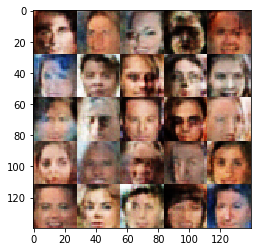

Epoch 0/1, Image 137600/202599: Loss of discriminator: 0.9296, Loss of generator: 1.4055
Epoch 0/1, Image 138240/202599: Loss of discriminator: 1.0349, Loss of generator: 0.9384
Epoch 0/1, Image 138880/202599: Loss of discriminator: 1.1519, Loss of generator: 0.7514
Epoch 0/1, Image 139520/202599: Loss of discriminator: 1.1590, Loss of generator: 0.7112
Epoch 0/1, Image 140160/202599: Loss of discriminator: 1.3363, Loss of generator: 0.6454


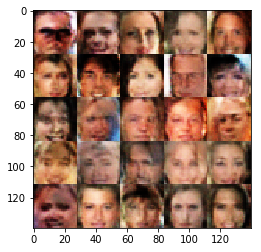

Epoch 0/1, Image 140800/202599: Loss of discriminator: 1.2318, Loss of generator: 0.7111
Epoch 0/1, Image 141440/202599: Loss of discriminator: 1.0728, Loss of generator: 1.1702
Epoch 0/1, Image 142080/202599: Loss of discriminator: 1.1792, Loss of generator: 0.9633
Epoch 0/1, Image 142720/202599: Loss of discriminator: 1.1283, Loss of generator: 0.7708
Epoch 0/1, Image 143360/202599: Loss of discriminator: 0.9754, Loss of generator: 0.9793


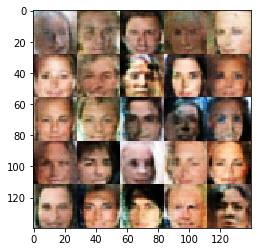

Epoch 0/1, Image 144000/202599: Loss of discriminator: 1.2441, Loss of generator: 0.7867
Epoch 0/1, Image 144640/202599: Loss of discriminator: 1.1624, Loss of generator: 0.9508
Epoch 0/1, Image 145280/202599: Loss of discriminator: 0.9027, Loss of generator: 1.1841
Epoch 0/1, Image 145920/202599: Loss of discriminator: 0.7837, Loss of generator: 1.2536
Epoch 0/1, Image 146560/202599: Loss of discriminator: 1.4975, Loss of generator: 0.5797


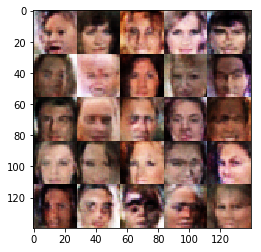

Epoch 0/1, Image 147200/202599: Loss of discriminator: 1.0048, Loss of generator: 0.9374
Epoch 0/1, Image 147840/202599: Loss of discriminator: 1.0101, Loss of generator: 0.9597
Epoch 0/1, Image 148480/202599: Loss of discriminator: 1.1856, Loss of generator: 0.6878
Epoch 0/1, Image 149120/202599: Loss of discriminator: 0.9608, Loss of generator: 1.1754
Epoch 0/1, Image 149760/202599: Loss of discriminator: 1.2312, Loss of generator: 0.5996


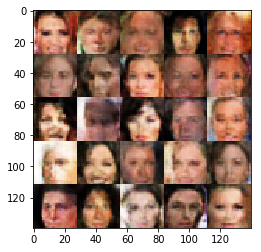

Epoch 0/1, Image 150400/202599: Loss of discriminator: 0.9297, Loss of generator: 1.0336
Epoch 0/1, Image 151040/202599: Loss of discriminator: 1.1134, Loss of generator: 0.8922
Epoch 0/1, Image 151680/202599: Loss of discriminator: 0.9732, Loss of generator: 0.9365
Epoch 0/1, Image 152320/202599: Loss of discriminator: 1.0612, Loss of generator: 1.0451
Epoch 0/1, Image 152960/202599: Loss of discriminator: 0.9630, Loss of generator: 1.1916


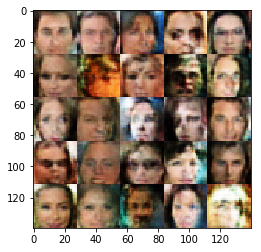

Epoch 0/1, Image 153600/202599: Loss of discriminator: 0.7238, Loss of generator: 1.5588
Epoch 0/1, Image 154240/202599: Loss of discriminator: 1.1233, Loss of generator: 1.2850
Epoch 0/1, Image 154880/202599: Loss of discriminator: 0.9891, Loss of generator: 1.3857
Epoch 0/1, Image 155520/202599: Loss of discriminator: 1.0057, Loss of generator: 0.9294
Epoch 0/1, Image 156160/202599: Loss of discriminator: 1.1871, Loss of generator: 0.6632


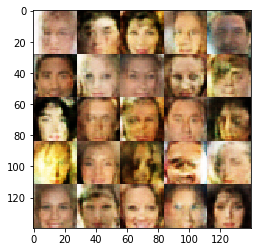

Epoch 0/1, Image 156800/202599: Loss of discriminator: 1.1732, Loss of generator: 0.8426
Epoch 0/1, Image 157440/202599: Loss of discriminator: 0.7619, Loss of generator: 1.2260
Epoch 0/1, Image 158080/202599: Loss of discriminator: 1.3173, Loss of generator: 0.6715
Epoch 0/1, Image 158720/202599: Loss of discriminator: 1.0934, Loss of generator: 1.0084
Epoch 0/1, Image 159360/202599: Loss of discriminator: 0.8655, Loss of generator: 1.2790


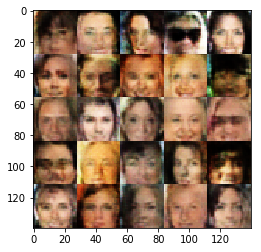

Epoch 0/1, Image 160000/202599: Loss of discriminator: 1.1655, Loss of generator: 0.6913
Epoch 0/1, Image 160640/202599: Loss of discriminator: 1.1006, Loss of generator: 0.9880
Epoch 0/1, Image 161280/202599: Loss of discriminator: 0.9783, Loss of generator: 1.0540
Epoch 0/1, Image 161920/202599: Loss of discriminator: 1.1517, Loss of generator: 0.8777
Epoch 0/1, Image 162560/202599: Loss of discriminator: 0.9715, Loss of generator: 0.9875


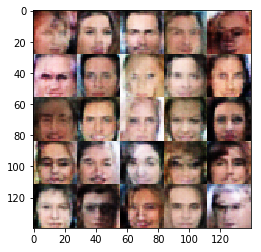

Epoch 0/1, Image 163200/202599: Loss of discriminator: 0.9974, Loss of generator: 0.9260
Epoch 0/1, Image 163840/202599: Loss of discriminator: 1.0631, Loss of generator: 0.8799
Epoch 0/1, Image 164480/202599: Loss of discriminator: 0.8646, Loss of generator: 1.3570
Epoch 0/1, Image 165120/202599: Loss of discriminator: 0.9547, Loss of generator: 0.9466
Epoch 0/1, Image 165760/202599: Loss of discriminator: 1.1744, Loss of generator: 0.7979


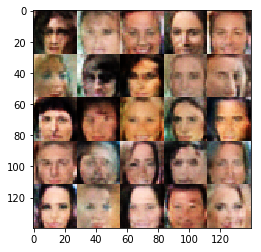

Epoch 0/1, Image 166400/202599: Loss of discriminator: 1.1126, Loss of generator: 1.0807
Epoch 0/1, Image 167040/202599: Loss of discriminator: 0.7982, Loss of generator: 1.2256
Epoch 0/1, Image 167680/202599: Loss of discriminator: 1.0457, Loss of generator: 0.7827
Epoch 0/1, Image 168320/202599: Loss of discriminator: 1.3015, Loss of generator: 0.6661
Epoch 0/1, Image 168960/202599: Loss of discriminator: 0.6761, Loss of generator: 1.9656


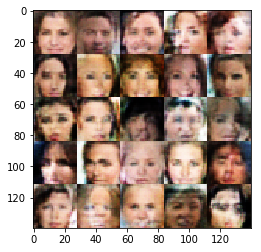

Epoch 0/1, Image 169600/202599: Loss of discriminator: 0.7574, Loss of generator: 1.5405
Epoch 0/1, Image 170240/202599: Loss of discriminator: 1.1390, Loss of generator: 1.0337
Epoch 0/1, Image 170880/202599: Loss of discriminator: 0.9453, Loss of generator: 1.1413
Epoch 0/1, Image 171520/202599: Loss of discriminator: 1.1424, Loss of generator: 1.1593
Epoch 0/1, Image 172160/202599: Loss of discriminator: 1.1603, Loss of generator: 0.7327


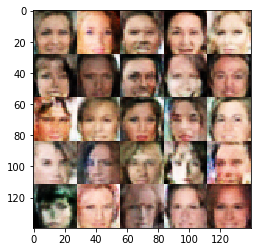

Epoch 0/1, Image 172800/202599: Loss of discriminator: 1.1956, Loss of generator: 0.8085
Epoch 0/1, Image 173440/202599: Loss of discriminator: 0.6709, Loss of generator: 1.6762
Epoch 0/1, Image 174080/202599: Loss of discriminator: 1.0844, Loss of generator: 1.8339
Epoch 0/1, Image 174720/202599: Loss of discriminator: 0.9590, Loss of generator: 0.9252
Epoch 0/1, Image 175360/202599: Loss of discriminator: 0.9695, Loss of generator: 1.0445


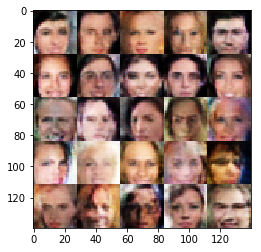

Epoch 0/1, Image 176000/202599: Loss of discriminator: 1.1258, Loss of generator: 0.8969
Epoch 0/1, Image 176640/202599: Loss of discriminator: 1.3936, Loss of generator: 1.3605
Epoch 0/1, Image 177280/202599: Loss of discriminator: 0.9412, Loss of generator: 1.0676
Epoch 0/1, Image 177920/202599: Loss of discriminator: 0.6415, Loss of generator: 1.8144
Epoch 0/1, Image 178560/202599: Loss of discriminator: 0.9586, Loss of generator: 1.0057


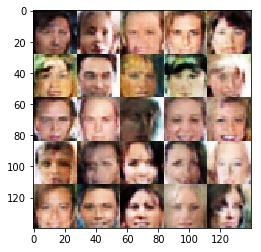

Epoch 0/1, Image 179200/202599: Loss of discriminator: 0.9360, Loss of generator: 1.0732
Epoch 0/1, Image 179840/202599: Loss of discriminator: 0.9485, Loss of generator: 1.7927
Epoch 0/1, Image 180480/202599: Loss of discriminator: 0.7270, Loss of generator: 1.4150
Epoch 0/1, Image 181120/202599: Loss of discriminator: 1.2992, Loss of generator: 0.5787
Epoch 0/1, Image 181760/202599: Loss of discriminator: 0.9293, Loss of generator: 1.1303


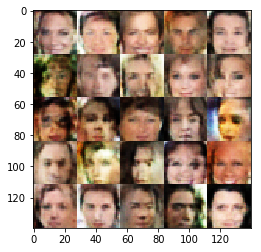

Epoch 0/1, Image 182400/202599: Loss of discriminator: 1.0550, Loss of generator: 0.8455
Epoch 0/1, Image 183040/202599: Loss of discriminator: 0.9812, Loss of generator: 1.0851
Epoch 0/1, Image 183680/202599: Loss of discriminator: 1.5384, Loss of generator: 1.5408
Epoch 0/1, Image 184320/202599: Loss of discriminator: 0.8933, Loss of generator: 1.0365
Epoch 0/1, Image 184960/202599: Loss of discriminator: 1.0043, Loss of generator: 1.3049


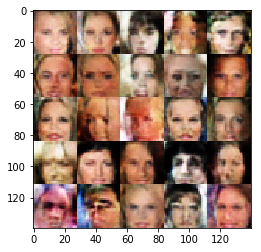

Epoch 0/1, Image 185600/202599: Loss of discriminator: 0.6853, Loss of generator: 2.2575
Epoch 0/1, Image 186240/202599: Loss of discriminator: 0.7530, Loss of generator: 1.3897
Epoch 0/1, Image 186880/202599: Loss of discriminator: 0.7891, Loss of generator: 1.8212
Epoch 0/1, Image 187520/202599: Loss of discriminator: 0.6926, Loss of generator: 2.0444
Epoch 0/1, Image 188160/202599: Loss of discriminator: 0.5737, Loss of generator: 2.0520


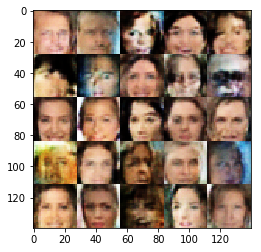

Epoch 0/1, Image 188800/202599: Loss of discriminator: 1.6684, Loss of generator: 0.3712
Epoch 0/1, Image 189440/202599: Loss of discriminator: 1.2389, Loss of generator: 0.5884
Epoch 0/1, Image 190080/202599: Loss of discriminator: 0.6714, Loss of generator: 1.5009
Epoch 0/1, Image 190720/202599: Loss of discriminator: 0.5848, Loss of generator: 3.8281
Epoch 0/1, Image 191360/202599: Loss of discriminator: 0.9618, Loss of generator: 0.9706


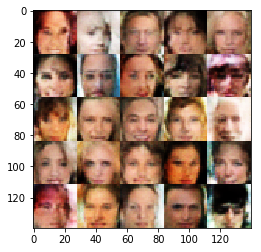

Epoch 0/1, Image 192000/202599: Loss of discriminator: 0.5677, Loss of generator: 2.5969
Epoch 0/1, Image 192640/202599: Loss of discriminator: 0.6320, Loss of generator: 1.9453
Epoch 0/1, Image 193280/202599: Loss of discriminator: 0.9825, Loss of generator: 1.3567
Epoch 0/1, Image 193920/202599: Loss of discriminator: 0.6447, Loss of generator: 1.6828
Epoch 0/1, Image 194560/202599: Loss of discriminator: 0.4876, Loss of generator: 3.1018


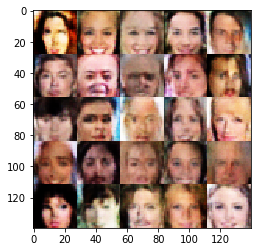

Epoch 0/1, Image 195200/202599: Loss of discriminator: 0.6236, Loss of generator: 2.7434
Epoch 0/1, Image 195840/202599: Loss of discriminator: 0.8501, Loss of generator: 1.1059
Epoch 0/1, Image 196480/202599: Loss of discriminator: 0.9302, Loss of generator: 1.1015
Epoch 0/1, Image 197120/202599: Loss of discriminator: 0.5167, Loss of generator: 2.5566
Epoch 0/1, Image 197760/202599: Loss of discriminator: 0.6941, Loss of generator: 1.4592


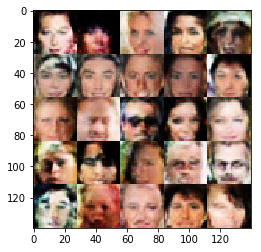

Epoch 0/1, Image 198400/202599: Loss of discriminator: 0.6400, Loss of generator: 1.9487
Epoch 0/1, Image 199040/202599: Loss of discriminator: 1.4930, Loss of generator: 0.4059
Epoch 0/1, Image 199680/202599: Loss of discriminator: 0.6326, Loss of generator: 1.5692
Epoch 0/1, Image 200320/202599: Loss of discriminator: 0.7733, Loss of generator: 1.2391
Epoch 0/1, Image 200960/202599: Loss of discriminator: 1.0157, Loss of generator: 0.8074


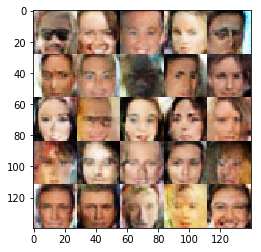

Epoch 0/1, Image 201600/202599: Loss of discriminator: 0.9921, Loss of generator: 0.9449
Epoch 0/1, Image 202240/202599: Loss of discriminator: 0.6629, Loss of generator: 1.6288


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.